In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tabulate import tabulate
from skimage.transform import resize
from monai.transforms import Resize
from models.unet_multidim import BasicUNet

from scripts.run_test import get_overlay
from utils.tools import load_checkpoint, mask_to_bbox_volumetric
from data.multidim_multilabel_dataset import Image_Dataset
from preprocessing.organ_labels_v2_volumetric import selected_organ_labels

/home/eytan/miniconda3/envs/label/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
test_data_file_path = '/home/eytan/storage/staff/eytankats/data/nako_10k/masks_volumetric_preprocessed_v2/test_masks_list.csv'
images_dir = '/home/eytan/storage/staff/eytankats/data/nako_10k/images_depth/'
volumes_dir = '/home/eytan/storage/staff/eytankats/data/nako_10k/images_mri_stitched/'
masks_dir = '/home/eytan/storage/staff/eytankats/data/nako_10k/masks_volumetric_preprocessed_v2/'
masks_pattern = '/home/eytan/storage/staff/eytankats/data/nako_10k/masks_volumetric_preprocessed_v2/*.nii.gz'
labels_file = '/home/eytan/storage/staff/eytankats/data/nako_10k/labels_processed_aggregated_v2.json'
experiment_dir = '/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/202506251345_multidim_multilabel_unet_processed_aggmasksv2/'
ckpt_path = '/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/202506251345_multidim_multilabel_unet_processed_aggmasksv2/checkpoints/best_valid_loss.pth'

In [3]:
df = pd.read_csv('/home/eytan/storage/staff/eytankats/projects/orgloc/experiments/202506251345_multidim_multilabel_unet_processed_aggmasksv2/results.csv')[:-2]
# df['experiment'] = 'multilabel_basicunet_filteredaggmasksv2'

In [4]:
def prepare_long_format(df, prefixes):
    rows = []
    for col in df.columns:
        for p in prefixes:
            if col.startswith(p + '_'):
                suffix = col[len(p) + 1:]

                rows.append({
                    'prefix': p,
                    'suffix': suffix,
                    'value': df[col],
                    # 'experiment': df['experiment']
                })
                break  # once matched, no need to check other prefixes
    long_df = pd.concat([
        pd.DataFrame({
            'prefix': row['prefix'],
            'suffix': row['suffix'],
            'value': row['value'],
            # 'experiment': row['experiment']
        }) for row in rows
    ], ignore_index=True)
    return long_df

def plot_grouped_by_prefix(df, prefixes, title, aspect_ratio=2.5, outliers=False):
    long_df = prepare_long_format(df, prefixes)

    sns.set_theme(style="whitegrid")
    g = sns.catplot(
        kind='box',
        data=long_df,
        x='suffix',
        y='value',
        hue='prefix',
        # col='experiment',  # if you want each experiment in its own subplot
        height=6,
        aspect=aspect_ratio,
        # legend=True,
        whis=(5, 95),
        width=.75,
        showfliers=outliers
    )

    g.set(xlabel='', ylabel='detection offset error (mm)', title=title)
    g.set_xticklabels(rotation=90)

    # g.add_legend(title='bbox')
    g._legend.set_bbox_to_anchor((1.1, 1))  # Right outside top corner
    # g._legend.set_loc('upper left')

    plt.tight_layout()

In [5]:
print(tabulate(df.head(10), headers='keys', tablefmt='psql'))

+----+--------+-------------+--------------+-----------------+-----------------+-----------------+------------------+---------------+----------------+-------------------+-------------------+-------------------+--------------------+---------------------+----------------------+-------------------------+-------------------------+-------------------------+--------------------------+--------------------+---------------------+------------------------+------------------------+------------------------+-------------------------+--------------+---------------+------------------+------------------+------------------+-------------------+
|    |   name |   left_mean |   right_mean |   superior_mean |   inferior_mean |   anterior_mean |   posterior_mean |   left_spleen |   right_spleen |   superior_spleen |   inferior_spleen |   anterior_spleen |   posterior_spleen |   left_kidney_right |   right_kidney_right |   superior_kidney_right |   inferior_kidney_right |   anterior_kidney_right |   posterior

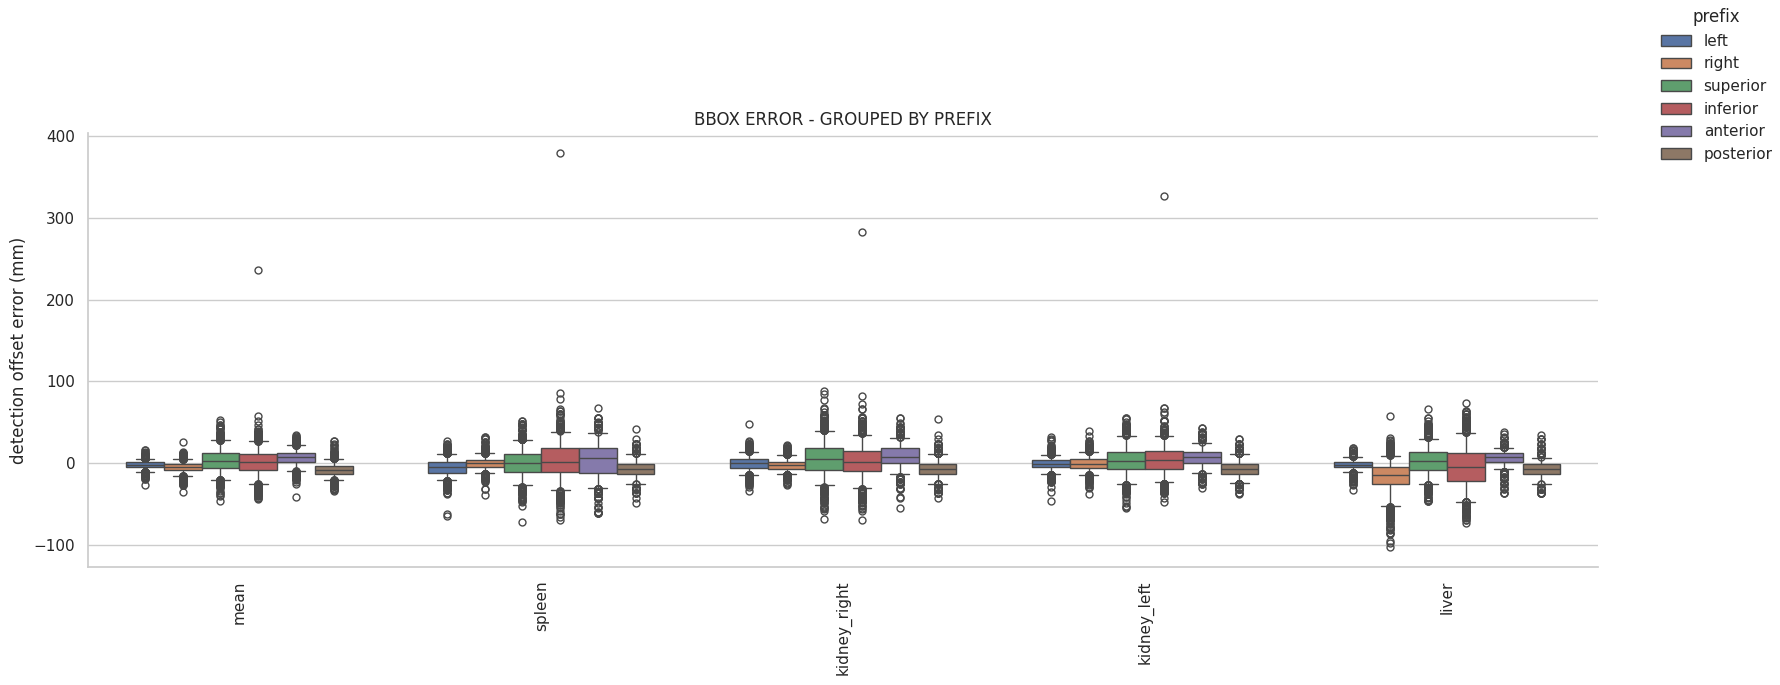

In [14]:
prefixes = ['left', 'right', 'inferior', 'superior', 'anterior', 'posterior']
plot_grouped_by_prefix(df, prefixes, title="BBOX ERROR - GROUPED BY PREFIX", outliers=True)

In [7]:
# Initialize dataset and model
test_dataset = Image_Dataset(test_data_file_path, images_dir=images_dir, masks_pattern=masks_pattern,
                                 labels_file=labels_file, stage='test')

model = BasicUNet(in_channels=3, out_channels=len(selected_organ_labels) + 1, dropout=False)
model = load_checkpoint(model, ckpt_path)

BasicUNet features: (64, 64, 128, 256, 512).
BasicUNet features: (16, 16, 32, 64, 128, 16).


In [11]:
def save_outliers(df, anatomy, side, ascending=True, vis_num=1):

    df_anatomy_side = df[['name', f'{side}_{anatomy}']]
    df_anatomy_side = df_anatomy_side.sort_values(by=f'{side}_{anatomy}', ascending=ascending)

    outliers_dir = os.path.join(experiment_dir, 'outliers', anatomy, side)
    os.makedirs(outliers_dir, exist_ok=True)

    for idx in range(0, vis_num):
        save_seg(df_anatomy_side.iloc[idx]['name'], outliers_dir, anatomy)

    print(tabulate(df_anatomy_side.head(vis_num), headers='keys', tablefmt='psql'))

In [9]:
def save_seg(sample, outliers_dir, anatomy):

    anatomy_idx = selected_organ_labels.index(anatomy)
    data_idx = test_dataset.name_list.index(sample)
    data = test_dataset[data_idx]

    img_rgb = data['img'].unsqueeze(0)

    if (img_rgb == 0).all():
        print(f'sample {sample} is all 0')
        return

    img_rgb = img_rgb / 255.0
    img_rgb = 2. * img_rgb - 1.

    seg_img = torch.stack(data['seg'], dim=0).float()
    seg_img = seg_img.unsqueeze(0).float()

    with torch.no_grad():
        pred_seg = torch.nn.functional.sigmoid(model(img_rgb))

    pred_resize_transform = Resize(spatial_size=(390, 480, 948))

    pred_anatomy = pred_seg[0, anatomy_idx + 1, :, :, :]
    pred_anatomy = pred_resize_transform(pred_anatomy.unsqueeze(0)).squeeze().detach().cpu().numpy()
    pred_anatomy_thr = np.float32(pred_anatomy > 0.5)

    path_to_save_pred = os.path.join(outliers_dir, f'{sample}_pred.nii.gz')
    pred_anatomy_nib = nib.Nifti1Image(pred_anatomy_thr.astype(np.float32), np.eye(4))
    nib.save(pred_anatomy_nib, path_to_save_pred)

    seg_anatomy = torch.zeros_like(seg_img)
    seg_anatomy[seg_img == anatomy_idx + 1] = 1
    seg_anatomy = seg_anatomy.squeeze()

    gt_resize_transform = Resize(spatial_size=(390, 480, 948), mode='nearest')
    seg_anatomy = gt_resize_transform(seg_anatomy.unsqueeze(0)).squeeze().numpy()

    path_to_save_gt = os.path.join(outliers_dir, f'{sample}_gt.nii.gz')
    seg_anatomy_nib = nib.Nifti1Image(seg_anatomy, np.eye(4))
    nib.save(seg_anatomy_nib, path_to_save_gt)

    volume_path = os.path.join(volumes_dir, sample, 'wat.nii.gz')
    volume = nib.load(volume_path).get_fdata()
    volume = np.flip(volume, axis=1)
    volume = torch.from_numpy(volume.copy()).float().permute(1, 0, 2)
    volume = pred_resize_transform(volume.unsqueeze(0)).squeeze().numpy()

    path_to_save_vol = os.path.join(outliers_dir, f'{sample}_vol.nii.gz')
    volume = nib.Nifti1Image(volume, np.eye(4))
    nib.save(volume, path_to_save_vol)


In [15]:
save_outliers(df, 'spleen', 'inferior', ascending=False, vis_num=2)

sample 111278 is all 0
+-----+--------+-------------------+
|     |   name |   inferior_spleen |
|-----+--------+-------------------|
| 211 | 111278 |               379 |
| 151 | 104282 |                86 |
+-----+--------+-------------------+
